In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from surprise import Dataset, Reader, NormalPredictor, KNNBasic, KNNWithZScore, KNNWithMeans, KNNWithZScore, SVD
from surprise.model_selection import train_test_split, cross_validate
from collections import defaultdict
from surprise import accuracy
import networkx as nx

In [70]:
df_review = pd.read_csv("yelp_academic_dataset_review.csv")
df_review = pd.DataFrame(df_review)

In [71]:
df_review.head(2)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18


In [2]:
df_business = pd.read_csv("yelp_academic_dataset_business.csv")
df_business = pd.DataFrame(df_business)

In [68]:
df_business.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",NaN
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."


In [ ]:
# df_user = pd.read_csv("yelp_academic_dataset_user.csv")
# df_user = pd.DataFrame(df_user)

In [34]:
# Filter the dataset to include only restaurants (as done previously)
df_restaurants = df_business[df_business["categories"].str.contains('Restaurants', na=False)]
len(df_restaurants)
# df_restaurants = df_restaurants[:100]

52268

In [31]:
unique_categories = set()

# Iterate through the categories and add them to the set
for category_string in df_restaurants['categories']:
    categories = category_string.split(', ')
    unique_categories.update(categories)

sorted_unique_categories = sorted(unique_categories)

print(len(sorted_unique_categories))
print(sorted_unique_categories)


728
['Acai Bowls', 'Accessories', 'Accountants', 'Active Life', 'Acupuncture', 'Adult', 'Adult Education', 'Adult Entertainment', 'Advertising', 'Afghan', 'African', 'Air Duct Cleaning', 'Airlines', 'Airport Lounges', 'Airport Shuttles', 'Airport Terminals', 'Airports', 'Amateur Sports Teams', 'American (New)', 'American (Traditional)', 'Amusement Parks', 'Animal Shelters', 'Antiques', 'Apartments', 'Appliances', 'Appliances & Repair', 'Aquariums', 'Arabic', 'Arcades', 'Argentine', 'Armenian', 'Art Classes', 'Art Galleries', 'Art Museums', 'Art Tours', 'Arts & Crafts', 'Arts & Entertainment', 'Asian Fusion', 'Auction Houses', 'Audio/Visual Equipment Rental', 'Australian', 'Austrian', 'Auto Customization', 'Auto Detailing', 'Auto Glass Services', 'Auto Loan Providers', 'Auto Parts & Supplies', 'Auto Repair', 'Automotive', 'Axe Throwing', 'Bagels', 'Bakeries', 'Bangladeshi', 'Banks & Credit Unions', 'Bar Crawl', 'Barbeque', 'Barbers', 'Bars', 'Bartenders', 'Basque', 'Battery Stores', 'Ba

Categorias a eliminar (exemplos): Acupuncture, Airport Lounges, Commercial Truck Repair, Day Spas, Eatertainment, Event Planning & Services, Fashion, Gas Stations, Hotels & Travel, Museums, Pet Adoption, Sports Wear^, 

In [48]:
relevant_categories = [  #select among these for example
    #'Restaurants',  #do not include this
     'American (Traditional)', 'Italian', 'Mexican', 
    'Chinese', 'Indian', 'Japanese', 'Cafes', 'Bakeries', 
    'Mediterranean', 'Fast Food', 'Buffets', 'Food Trucks', 
    'Bars', 'Pubs', 'Steakhouses', 
    'Sushi Bars', 'Breakfast & Brunch', 'Sandwiches', 
    'Pizza', 'Seafood', 'Cocktail Bars', 'Ice Cream & Frozen Yogurt', 
    'Coffee & Tea', 'Desserts',  'Barbeque', 
    'Food Stands', 'Homemade', 
    'Street Food', 'Bistro', 
    'Sustainable Restaurants'
]

In [59]:
set_categorias_relevantes = set(relevant_categories)

df_restaurants['relevant_categories'] = df_restaurants['categories'].apply(
    lambda x: [cat for cat in x.split(', ') if cat in set_categorias_relevantes]
)

# print(df_restaurants[['categories', 'relevant_categories']])


Temos de fazer o grafo pelas categorias relevantes. Se usarmos só as categorias todas, fica um círculo preto impossível de ler

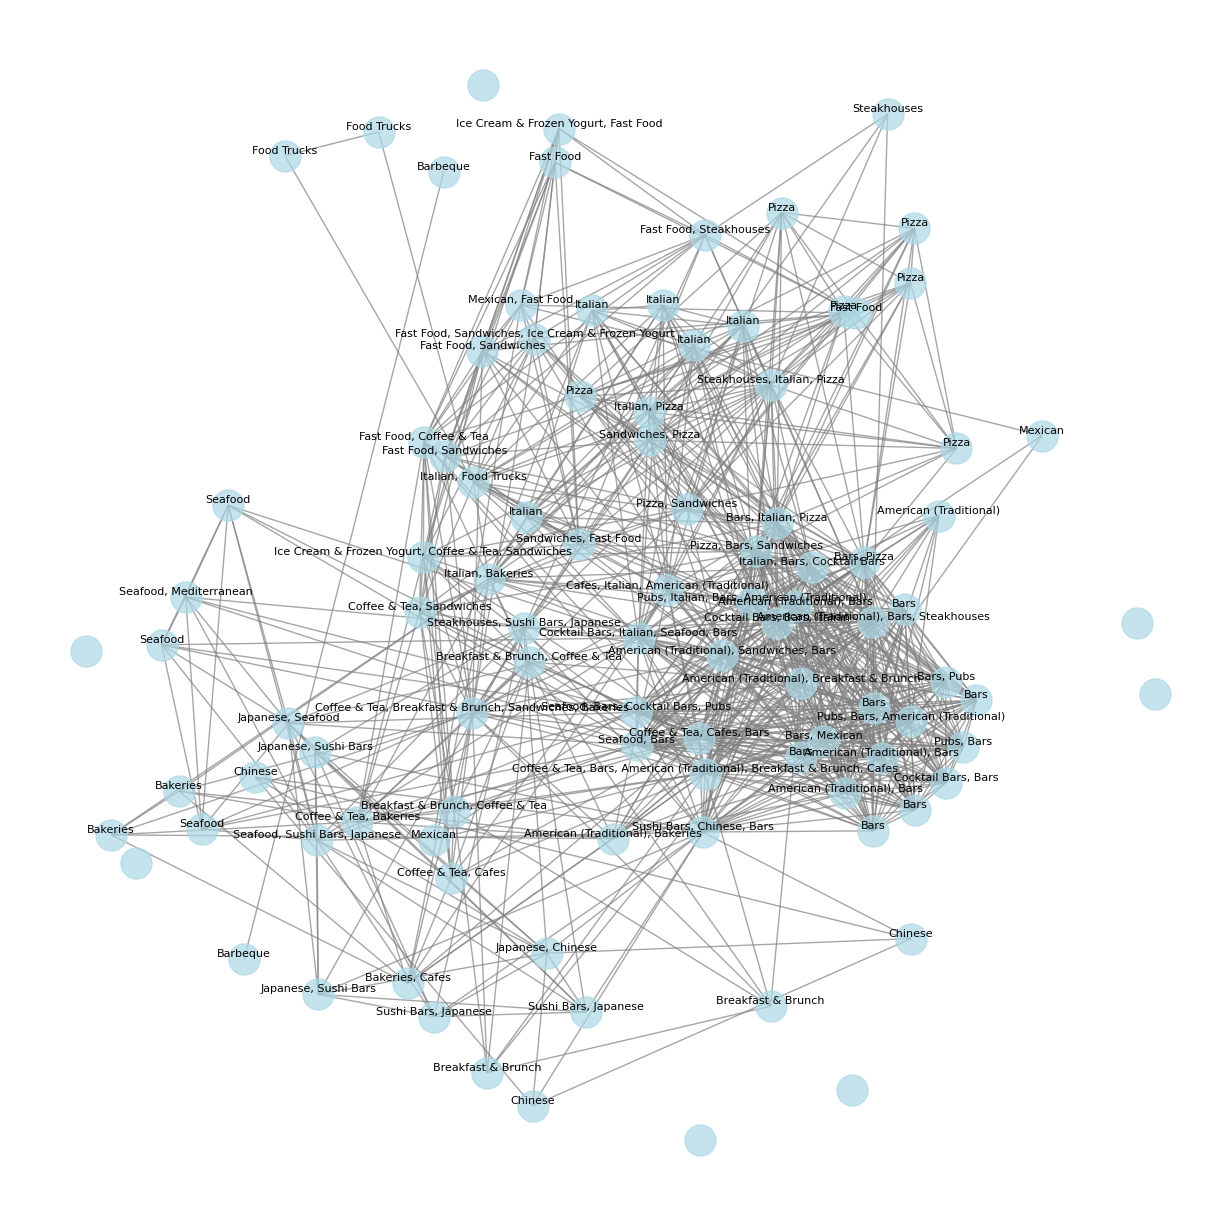

In [58]:
G = nx.Graph()

for idx, row in df_restaurants.iterrows():
    restaurant_id = row['business_id']
    categories = row['relevant_categories']  

    G.add_node(restaurant_id, relevant_categories=', '.join(categories)) 

# Criar arestas entre restaurantes que compartilham categorias
for idx1, row1 in df_restaurants.iterrows():
    for idx2, row2 in df_restaurants.iterrows():
        if idx1 < idx2:  # Evitar pares duplicados e auto-laços
            categories1 = set(row1['relevant_categories'])
            categories2 = set(row2['relevant_categories'])
            # Se eles compartilham pelo menos uma categoria, criar uma aresta
            if categories1 & categories2:  
                G.add_edge(row1['business_id'], row2['business_id'])

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.9)  # Aumentar a força de repulsão

nx.draw(G, pos, with_labels=False, node_size=500, edge_color="gray", alpha=0.7, node_color="lightblue")

labels = {node: G.nodes[node]['relevant_categories'] for node in G.nodes}

offsets = {node: (0.1, 0.1) for node in G.nodes}  #

nx.draw_networkx_labels(G, pos, labels, font_size=8, font_color="black", verticalalignment='bottom')

plt.show()


In [69]:
from collections import Counter

G = nx.Graph()

for idx, row in df_restaurants.iterrows():
    restaurant_id = row['name'] 
    categories = row['relevant_categories']  
    
    G.add_node(restaurant_id, relevant_categories=categories)

    for category in categories:
        G.add_edge(restaurant_id, category)  

# Detect communities within the graph
communities = nx.algorithms.community.greedy_modularity_communities(G)

# Display the communities and their sizes
for i, community in enumerate(communities):
    print(f"Community {i + 1}: {len(community)} restaurants")  
    
    restaurant_ids = [restaurant for restaurant in community if restaurant in df_restaurants['name'].values]
    print(f"Restaurants: {restaurant_ids}\n") 
    common_categories = []
    for restaurant in restaurant_ids:
        categories = G.nodes[restaurant]['relevant_categories']  
        common_categories.extend(categories) 
    
    # Count occurrences of each category
    category_counts = Counter(common_categories)  
    print(f"Most common categories: {category_counts.most_common(3)}\n")  

Community 1: 25 restaurants
Restaurants: ['Bar One', "Doc Magrogan's Oyster House - West Chester", 'Altamura', 'Sunset 44 Bistro', 'Roman Forum', 'Chrysalis', "Eat Mah Taco @ Pal's Lounge", "Sal DeForte's Ristorante", "Romano's Macaroni Grill", "Tsevi's Pub And Grill", 'Gavi Italian Restaurant', 'The Libertine Liquor Bar', 'Home Plate Sports Pub', 'Village Tap Room', 'Core de Roma', 'Top Shelf Sports Lounge', 'Four Green Fields', "Rosati's Pizza", "Nipper's Pub", "O'Briens Irish Pub", 'Copper Vine']

Most common categories: [('Bars', 16), ('Italian', 10), ('Cocktail Bars', 5)]

Community 2: 18 restaurants
Restaurants: ['Caviar & Bananas', "Zio's Italian Market", 'Express Cafe', 'Red Hook Coffee & Tea', 'Bagelicious - King Of Prussia', 'Helena Avenue Bakery', 'Paws The Cat Cafe', 'St Honore Pastries', 'Brown Sugar Bakery & Cafe', 'Baltic Bakery', 'Roast Coffeehouse and Wine Bar', 'Craft Hall', 'Cafe Con Leche', "Bub's Cafe"]

Most common categories: [('Coffee & Tea', 7), ('Bakeries', 7)

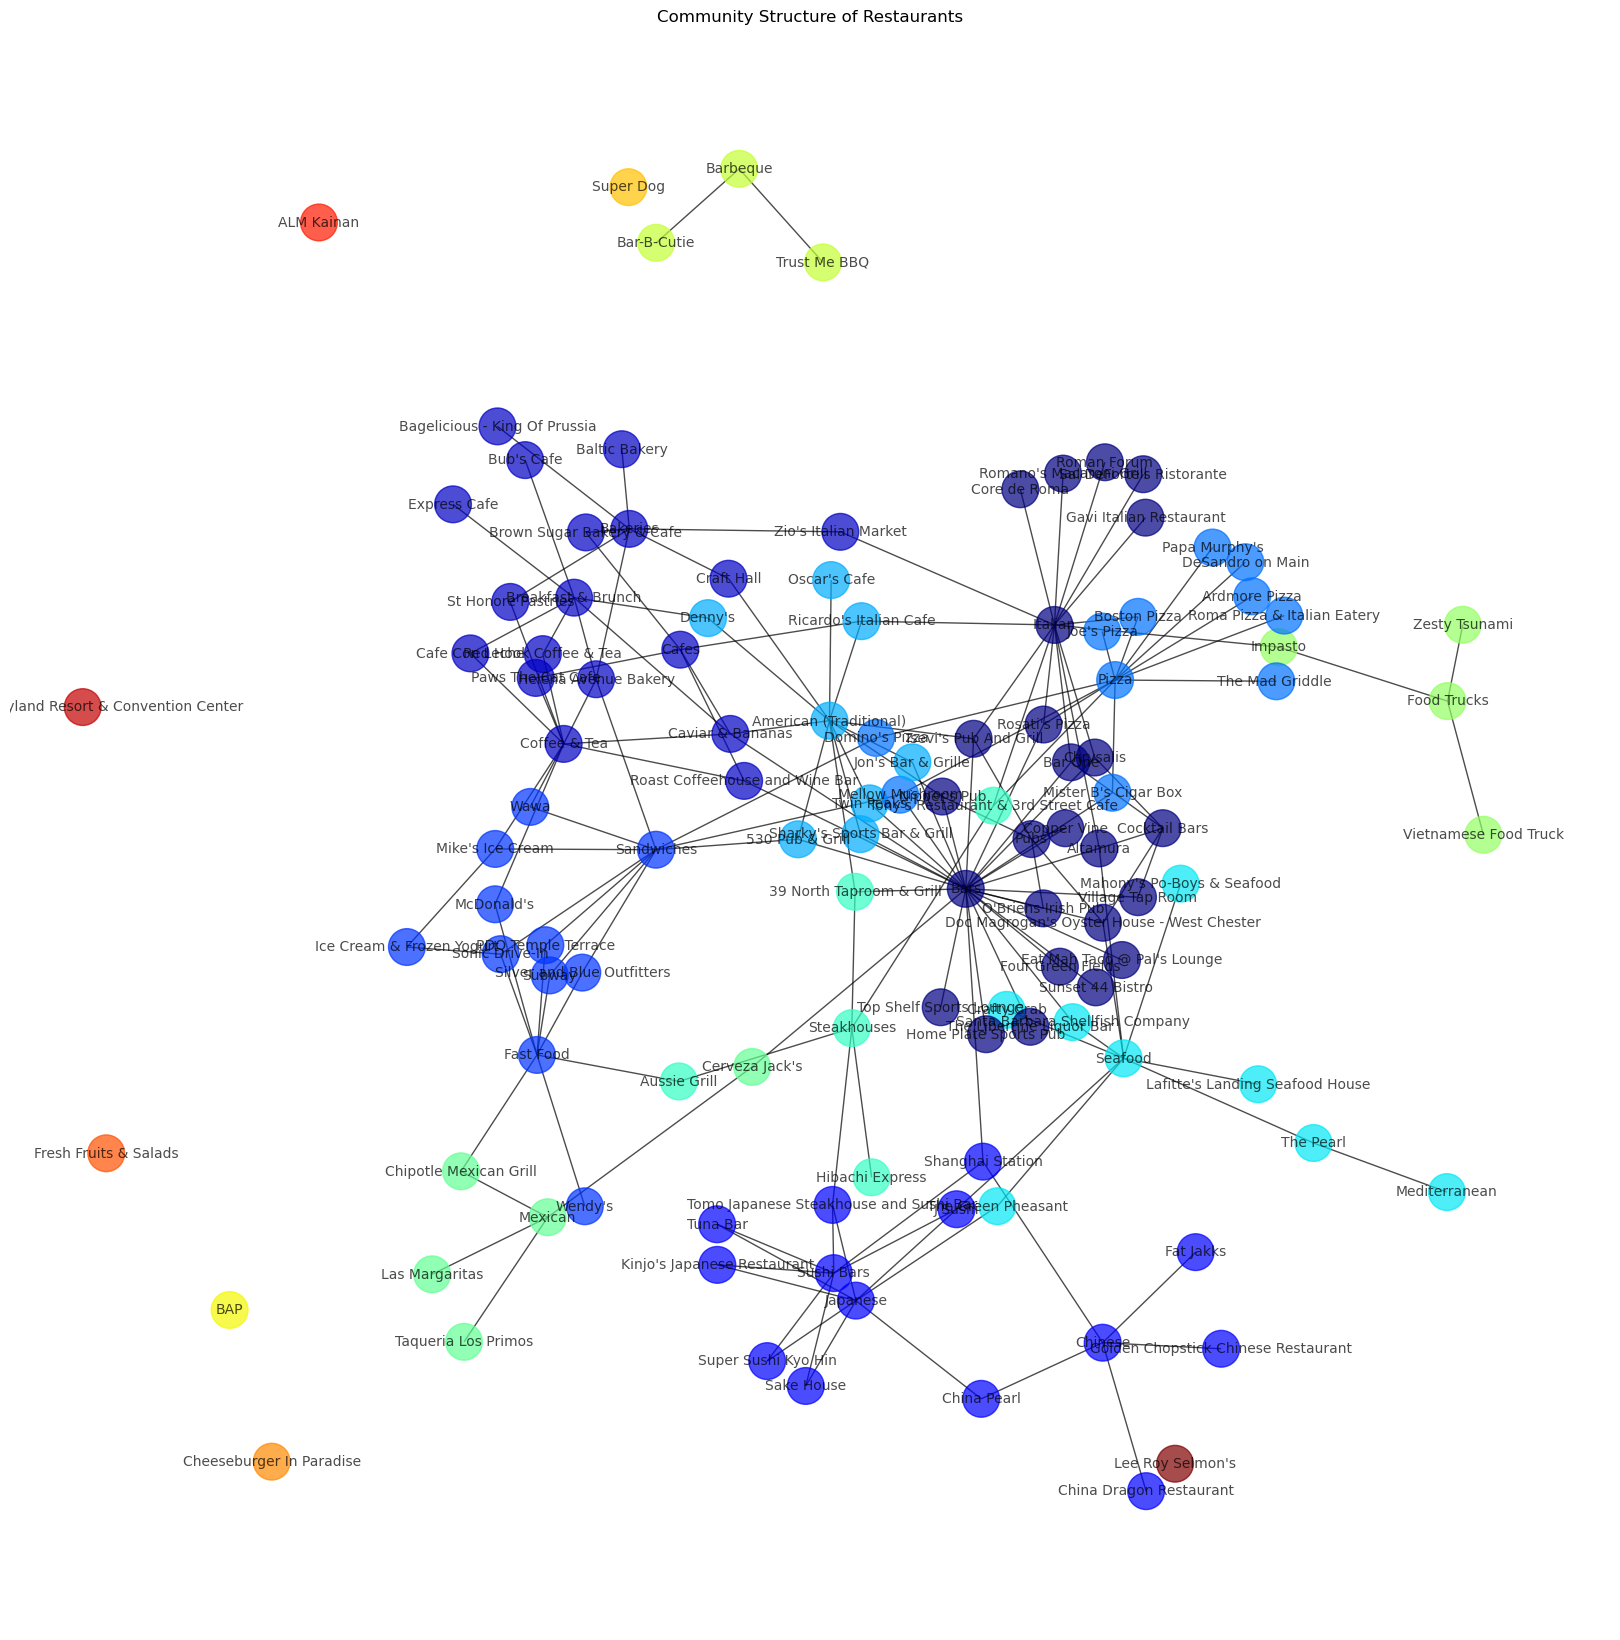

In [74]:
plt.figure(figsize=(16, 16))  

color_map = [0] * G.number_of_nodes()  # Default color for nodes
for idx, node in enumerate(G.nodes()):
    for i, community in enumerate(communities):
        if node in community:
            color_map[idx] = i  # Assign color based on community index
            break

pos = nx.spring_layout(G, k=0.2)  # Adjust k for more spacing between nodes

nx.draw(G, pos, node_color=color_map, with_labels=True, font_size=10, node_size=700, alpha=0.7, cmap=plt.cm.jet)

plt.title('Community Structure of Restaurants')
plt.show()

